In [16]:
import json
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import clip
from transformers import CLIPProcessor, CLIPModel

import open_clip
import cv2
from sentence_transformers import util

import os
from torchvision import transforms as T
import pandas as pd
from Utils.Dataloader import CropDataset
import matplotlib.pyplot as plt
from Utils.TextToImage import unique_char_mapping
from Utils.Filters import applyTransforms

from PIL import Image
import numpy as np
import torch

from SketchKeras.sketch_model import SketchKeras
import Utils.sketchkeras as SK 
import Utils.Predict as P 

PATCH_SIZE = 64

In [17]:

device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, preprocess = open_clip.create_model_and_transforms('ViT-B-16-plus-240', pretrained="laion400m_e32")
model.to(device)

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 896, kernel_size=(16, 16), stride=(16, 16), bias=False)
    (patch_dropout): Identity()
    (ln_pre): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): ModuleList(
        (0-11): 12 x ResidualAttentionBlock(
          (ln_1): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=896, out_features=896, bias=True)
          )
          (ls_1): Identity()
          (ln_2): LayerNorm((896,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=896, out_features=3584, bias=True)
            (gelu): GELU(approximate='none')
            (c_proj): Linear(in_features=3584, out_features=896, bias=True)
          )
          (ls_2): Identity()
        )
      )
    )
    (ln_post): LayerNorm((896,), eps=1e-05, elementwise_affine

In [18]:
def imageEncoder(img):
    img1 = Image.fromarray(img).convert('RGB')
    img1 = preprocess(img1).unsqueeze(0).to(device)
    img1 = model.encode_image(img1)
    return img1

In [19]:
def generateScore(image1, image2):
    # test_img = cv2.imread(image1, cv2.IMREAD_UNCHANGED)
    # data_img = cv2.imread(image2, cv2.IMREAD_UNCHANGED)
    img1 = imageEncoder(image1)
    img2 = imageEncoder(image2)
    cos_scores = util.pytorch_cos_sim(img1, img2)
    score = round(float(cos_scores[0][0])*100, 2)
    return score

In [20]:
def extract_patches(image, n, m):  
    patches = []
    image = np.array(image)
    height, width = image.shape[:2]
    images_height =0
    images_width = 0

    for y in range(0, height - n + 1, m):
        images_height += 1
        for x in range(0, width - n + 1, m):  
            images_width += 1          
            patch = image[y:y+n, x:x+n]
            patches.append(patch)
    images_width = images_width//images_height

    return np.array([patch for patch in patches]), images_width, images_height

In [21]:
image = Image.open("sit_toyosu.png").resize((1024,1024))
sketch = Image.open("sketch.png").resize((1024,1024))

In [22]:
ascii_imgs, _, _ = extract_patches(Image.open('output.png'), PATCH_SIZE, PATCH_SIZE)
sketch_imgs, _, _ = extract_patches(sketch, PATCH_SIZE, PATCH_SIZE)

In [23]:
scores = []

for ascii_img, sketch_img in zip(ascii_imgs, sketch_imgs):
    scores.append(generateScore(ascii_img, sketch_img))

In [24]:
big = Image.open('sit_toyosu.png').convert("L").resize((7680,4096))
tone_imgs, _, _ = extract_patches(Image.open('converted_sit_toyosu.png'), PATCH_SIZE*8, PATCH_SIZE*8)
normal_imgs, _, _ = extract_patches(big, PATCH_SIZE*8, PATCH_SIZE*8)

In [25]:
scores_tone = []
for tone_img, normal_img in zip(tone_imgs, normal_imgs):
    scores_tone.append(generateScore(tone_img, normal_img))

In [26]:
for i, score in enumerate(scores):
    print(f'Image {i} : {(score):.2f}%')
    # plt.subplot(1, 2, 1)
    # plt.imshow(ascii_imgs[i], cmap='gray')
    # plt.subplot(1, 2, 2)
    # plt.imshow(normal_imgs[i], cmap='gray')
    # plt.show()

Image 0 : 100.00%
Image 1 : 100.00%
Image 2 : 100.00%
Image 3 : 89.03%
Image 4 : 59.18%
Image 5 : 53.07%
Image 6 : 49.72%
Image 7 : 82.87%
Image 8 : 100.00%
Image 9 : 100.00%
Image 10 : 100.00%
Image 11 : 100.00%
Image 12 : 100.00%
Image 13 : 100.00%
Image 14 : 100.00%
Image 15 : 100.00%
Image 16 : 100.00%
Image 17 : 100.00%
Image 18 : 100.00%
Image 19 : 100.00%
Image 20 : 100.00%
Image 21 : 100.00%
Image 22 : 100.00%
Image 23 : 100.00%
Image 24 : 100.00%
Image 25 : 100.00%
Image 26 : 100.00%
Image 27 : 100.00%
Image 28 : 100.00%
Image 29 : 100.00%
Image 30 : 100.00%
Image 31 : 100.00%
Image 32 : 100.00%
Image 33 : 100.00%
Image 34 : 100.00%
Image 35 : 91.93%
Image 36 : 67.04%
Image 37 : 43.32%
Image 38 : 89.39%
Image 39 : 43.30%
Image 40 : 100.00%
Image 41 : 100.00%
Image 42 : 100.00%
Image 43 : 100.00%
Image 44 : 100.00%
Image 45 : 100.00%
Image 46 : 100.00%
Image 47 : 100.00%
Image 48 : 100.00%
Image 49 : 100.00%
Image 50 : 100.00%
Image 51 : 100.00%
Image 52 : 100.00%
Image 53 : 10

In [27]:
for i, score_tone in enumerate(scores_tone):
    print(f'Image {i} : {(score_tone):.2f}%')
    # plt.subplot(1, 2, 1)
    # plt.imshow(ascii_imgs[i], cmap='gray')
    # plt.subplot(1, 2, 2)
    # plt.imshow(normal_imgs[i], cmap='gray')
    # plt.show()

Image 0 : 34.79%
Image 1 : 30.45%
Image 2 : 33.81%
Image 3 : 29.54%
Image 4 : 26.80%
Image 5 : 23.39%
Image 6 : 26.32%
Image 7 : 25.29%
Image 8 : 33.17%
Image 9 : 27.07%
Image 10 : 30.21%
Image 11 : 30.32%
Image 12 : 31.74%
Image 13 : 33.55%
Image 14 : 34.67%
Image 15 : 35.27%
Image 16 : 36.11%
Image 17 : 35.33%
Image 18 : 35.27%
Image 19 : 35.74%
Image 20 : 35.76%
Image 21 : 35.25%
Image 22 : 35.91%
Image 23 : 35.42%
Image 24 : 35.87%
Image 25 : 35.47%
Image 26 : 32.30%
Image 27 : 35.91%
Image 28 : 35.17%
Image 29 : 35.24%
Image 30 : 29.58%
Image 31 : 36.34%
Image 32 : 33.92%
Image 33 : 28.20%
Image 34 : 24.70%
Image 35 : 27.53%
Image 36 : 26.25%
Image 37 : 22.92%
Image 38 : 24.44%
Image 39 : 33.22%
Image 40 : 31.38%
Image 41 : 34.44%
Image 42 : 33.24%
Image 43 : 30.03%
Image 44 : 28.68%
Image 45 : 35.10%
Image 46 : 35.50%
Image 47 : 35.38%
Image 48 : 35.47%
Image 49 : 36.14%
Image 50 : 35.63%
Image 51 : 35.62%
Image 52 : 35.60%
Image 53 : 35.70%
Image 54 : 36.23%
Image 55 : 35.52%
Im

Image similarity : 29.79%


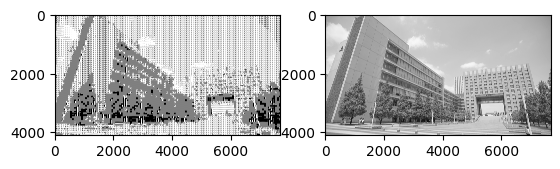

In [28]:
image_mean = np.array(scores_tone).mean()
print(f'Image similarity : {(image_mean):.2f}%')
plt.subplot(1, 2, 1)
plt.imshow(Image.open("converted_sit_toyosu.png"), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(big, cmap='gray')
plt.show()

Image similarity : 72.75%


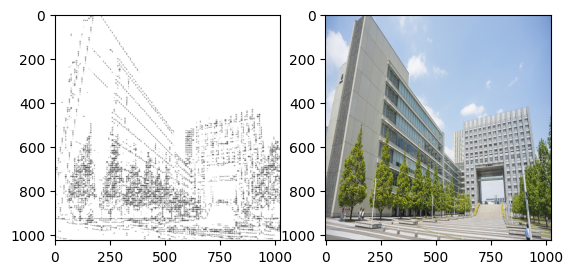

In [29]:
image_mean = np.array(scores).mean()
print(f'Image similarity : {(image_mean):.2f}%')
plt.subplot(1, 2, 1)
plt.imshow(Image.open("output.png"), cmap='gray')
plt.subplot(1, 2, 2)
plt.imshow(image)
plt.show()